In [31]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import argparse
import modules.random_graph as random_graph
import logging
import modules.weight as weight
import modules.A_mat as A_mat
import modules.pramameters as pramameters
import modules.population as population
import modules.plotGraph as plotGraph
import modules.simulation as simulation
import modules.utils as utils
import modules.nn as nn
import modules.evaluate as evaluate

#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
#preset
# paras.modelLoad= "BB"
# paras.randomGraph= "GEO"
# paras.weightModel= "identical"
# paras.epoches= 100
# paras.intense= 0
# paras.modelLoad= "BA"
# paras.plot= "spring"
# paras.epoches= 50000
# paras.randomGraph= "BA"
# paras.weightModel= "identical"
# paras.seed= 20
#paras.dense= 8


random.seed(paras.seed)

#results and logs file name
fileName= f"{paras.modelLoad}/{paras.modelLoad}_{paras.randomGraph}_{paras.weightModel}_{paras.seed}_{paras.strains}_{paras.intense}_{paras.epoches}"

printFlag= 0
if printFlag!=1:
    logging.basicConfig(filename="logs/"+paras.modelLoad+".log", level=logging.INFO)

plotFlag= 0

device= paras.device if torch.cuda.is_available() else "cpu"


P= population.population(paras.n, device= device)

# generate random graphs: GEO(defult), ER, WS, BA'
if paras.randomGraph=="GEO":
    A, G, pos= random_graph.get_Geo_random_contact(paras.n, radius=0.4, device= device)
elif paras.randomGraph=="BA":
    A, G= random_graph.get_BA_random_contact(paras.n, paras.dense, device= device)
elif paras.randomGraph=="WS":
    A, G= random_graph.get_WS_random_contact(paras.n, paras.dense*2, 0.3,device= device)
elif paras.randomGraph=="ER":
    A, G= random_graph.get_ER_random_contact(paras.n, paras.dense, device= device)

#assign adjacency weight to matrix: degree(defult), gravity

if paras.weightModel=="degree":
    Aw= weight.degree_model(A, P= P, device=device)
elif  paras.weightModel=="gravity":
    Aw= weight.gravity_model(G, pos, P, device= device)
elif  paras.weightModel=="identical":
    Aw= weight.identical_model(A, 0.01, device= device)

utils.log_print(printFlag,"\n\n\n.........................initialize..........................")
utils.log_print(printFlag,"FileName:", fileName)
utils.log_print(printFlag,"Using", paras.randomGraph,"random graph model")
utils.log_print(printFlag,"Num of links:", G.number_of_edges())
Zmat= A_mat.create_A_mat(Aw, P)
Zmat2= A_mat.reverse_A_mat(Zmat-torch.eye(Aw.shape[0], dtype= torch.float32, device= Aw.device), P)
utils.log_print(printFlag,"Reverse ZERO:", torch.sum(torch.abs(Zmat2-Aw)))
utils.log_print(printFlag,"Num links weight bigger than 0.1:", torch.sum(Zmat>0.1)-paras.n)
utils.log_print(printFlag,"Num links weight bigger than 0.05:", torch.sum(Zmat>0.05)-paras.n)
utils.log_print(printFlag,"Num links weight bigger than 0.01:", torch.sum(Zmat>0.01)-paras.n)
utils.log_print(printFlag,".............................................................")
#plot this network
if plotFlag==1:
    if paras.plot== "2d_geo":
        plotGraph.plot_2d_geo(G, pos)
    elif paras.plot== "spring":
        plotGraph.plot_spring_layout(G)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
R0s_taus= [[random.uniform(paras.R0Mean-paras.R0Std, paras.R0Mean+paras.R0Std), 
            random.uniform(paras.tauMean-paras.tauStd, paras.tauMean+paras.tauStd)] for _ in range(40)]
paras.R0s=  [ R0s_taus[i][0] for i in range(40)]
paras.taus= [ R0s_taus[i][1] for i in range(40)]
utils.log_print(printFlag,paras.R0s)
utils.log_print(printFlag,paras.taus)
deltaSsTensor= simulation.multi_strains(G, paras, Zmat, intense= paras.intense, device= device)
deltaSs= deltaSsTensor.sum(dim= -1, keepdim= True)
propition= deltaSsTensor/(deltaSs+1e-8)
deltaSs= deltaSs.squeeze()#(1, 2, 20), dim of nodes, dim of heads, dim of signal
divide= deltaSsTensor.transpose(1, 2)
utils.log_print(printFlag,divide.shape)
if plotFlag==1:
    numPlot= 4
    fig, axs = plt.subplots(numPlot, 1, figsize=(10, 4))
    for i, ax in enumerate(axs):
        ax.plot(deltaSs[i, :].cpu().detach())
    # plt.xlabel("Time(days)")
    # plt.ylabel("Propotion of newly infective")
    # plt.title(f"Example of {numPlot} nodes epidemic newly infected.")

In [33]:
timeHorizon= divide.shape[2]-1
if   paras.modelLoad=="AA":
    myMatch= nn.matchingA(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= nn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AB":
    myMatch= nn.matchingA(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= nn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BA":
    myMatch= nn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= nn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BB":
    myMatch= nn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= nn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="infer2018":
    myMatch= nn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= nn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
    
optimizer1 = torch.optim.Adam(myMatch.parameters(),lr=2e-4)
optimizer2 = torch.optim.Adam({myEpi.taus},lr=2e-4)
optimizer3 = torch.optim.Adam({myEpi.R0dTaus},lr=2e-4)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []

In [29]:
if paras.modelLoad== "infer2018":
    for j in tqdm(range(paras.strains)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        inferZmat= myMatch(divide)
        predSignal, signal, PreZ= myEpi(divide, inferZmat)
        loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()+1e-3*torch.sum(torch.log(torch.sum(inferZmat, dim= 1)))
        losses.append((loss-1e-3*torch.sum(torch.log(torch.sum(inferZmat, dim= 1)))).item())
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
else:
    for j in tqdm(range(paras.strains)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        inferZmat= myMatch(divide)
        predSignal, signal, PreZ= myEpi(divide, inferZmat)
        loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()
        losses.append(loss.item())
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()

utils.log_print(printFlag,loss/timeHorizon*100)#
#1， 2， 3， 4
#0.0145, 0.0073, 0.0066，0.0050
#0.0081, 0.0068, 0.0049, 0.0044
#0.0118, 0.0087, 0.0093, 0.0116
#0.0191, 0.0178, 0.0150, 0.0114
#0.0117, 

100%|██████████| 300/300 [00:00<00:00, 408.76it/s]

tensor(148.4008, device='cuda:0', grad_fn=<MulBackward0>)


In [18]:
print(1e-3*torch.sum(torch.log(torch.sum(inferZmat, dim= 1))))

tensor(0.1481, device='cuda:0', grad_fn=<MulBackward0>)


In [19]:
print(inferZmat.sum(dim=1))

tensor([19.3407, 19.3220, 19.3315, 19.3198, 19.3271, 19.3235, 19.3166, 19.3167,
        19.3631, 19.3325, 19.3331, 19.3207, 19.3197, 19.3215, 19.3230, 19.3292,
        19.3300, 19.3255, 19.3111, 19.3208, 19.3225, 19.3268, 19.3216, 19.3199,
        19.3233, 19.3250, 19.3242, 19.3277, 19.3230, 19.3159, 19.3192, 19.3253,
        19.3642, 19.3209, 19.3208, 19.3289, 19.3204, 19.3224, 19.3761, 19.3317,
        19.3678, 19.3236, 19.3246, 19.3279, 19.3335, 19.3317, 19.3311, 19.3309,
        19.3320, 19.3362], device='cuda:0', grad_fn=<SumBackward1>)


In [30]:
#save: A, preA, losses, taus, pretaus, R0s, preR0s, [errors]
thred= 1e-3
utils.log_print(printFlag,paras.taus[0: paras.strains])
utils.log_print(printFlag,paras.R0s[0: paras.strains])
utils.log_print(printFlag,myEpi.taus[0])
utils.log_print(printFlag,(myEpi.taus*myEpi.R0dTaus)[0])
PreA= A_mat.reverse_A_mat(PreZ-torch.eye(paras.n, device= device), P)
utils.log_print(printFlag,"err1:", torch.sqrt((PreA-Aw)**2).sum())
utils.log_print(printFlag,"err2:", ((PreA>thred)^(Aw>thred)).sum())
utils.log_print(printFlag,"cosine similarity:", evaluate.cosine_similarity(Aw, PreA))
utils.log_print(printFlag,"cosine similarity 2:", evaluate.cosine_similarity(Aw>thred, PreA>thred))
utils.log_print(printFlag,"spectral_analysis:", evaluate.spectral_analysis(Aw, PreA))
utils.log_print(printFlag,"edge_correctness:", evaluate.edge_correctness(Aw>thred, PreA>thred))
utils.log_print(printFlag,"jaccard_index:", evaluate.jaccard_index(Aw>thred, PreA>thred))
utils.log_print(printFlag,torch.var(myEpi.taus, dim= 0))
utils.log_print(printFlag,torch.var(myEpi.R0dTaus, dim= 0))
utils.log_print(printFlag,torch.sum(predSignal[29, :, 0:-1])/paras.strains)
utils.log_print(printFlag,torch.sum(signal[29, :, 1:])/paras.strains)
startV= 5
deltaV= 6
utils.log_print(printFlag,PreA[startV:startV+deltaV, startV:startV+deltaV])
utils.log_print(printFlag,Aw[startV:startV+deltaV, startV:startV+deltaV])
np.savez("results/"+fileName+".npz", A= Aw.cpu().detach(), Apre= PreA.cpu().detach(), 
         cosine_similarity= evaluate.cosine_similarity(Aw, PreA).item(),
         loss= losses, taus= paras.taus, r0s= paras.R0s, tausP= myEpi.taus.cpu().detach(), 
         r0sP= (myEpi.R0dTaus*myEpi.taus).cpu().detach(), signal= signal.cpu().detach(), predSignal= predSignal.cpu().detach())

#utils.log_print(printFlag,tempZmat)
err1s=[[17.4788, 5.8208, 4.3792, 3.0708],
       [14.9636, 5.3225, 2.9503, 2.2976],
       [16.8350, 7.7293, 7.8189, 6.2680],
       [12.9897, 24.1358, 7.4208, 6.6149],
       [15.8859]]
err2s=[[847, 622, 435, 389],
       [812, 557, 390, 299],
       [1011, 658, 684, 630],
       [1079, 895, 638, 597],
       [1060, ]]


[6.1697417618728645]
[12.167429126612046]
tensor([6.1428], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([7.9412], device='cuda:0', grad_fn=<SelectBackward0>)
err1: tensor(61.8588, device='cuda:0', grad_fn=<SumBackward0>)
err2: tensor(1774, device='cuda:0')
cosine similarity: tensor(0.3651, device='cuda:0', grad_fn=<DivBackward0>)
cosine similarity 2: tensor(0.5236, device='cuda:0')
spectral_analysis: tensor(0.4519, device='cuda:0', grad_fn=<DivBackward0>)
edge_correctness: tensor(0.9985, device='cuda:0')
jaccard_index: tensor(0.2744, device='cuda:0')
tensor([4.0002e-08], device='cuda:0', grad_fn=<VarBackward0>)
tensor([6.5905e-08], device='cuda:0', grad_fn=<VarBackward0>)
tensor(1.5894, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0000, device='cuda:0')
tensor([[0.0000, 0.0194, 0.0147, 0.0075, 0.0197, 0.1163],
        [0.0033, 0.0000, 0.0353, 0.0435, 0.0117, 0.0659],
        [0.0103, 0.0062, 0.0000, 0.0608, 0.0178, 0.1035],
        [0.0055, 0.0043, 0.0459, 0.0000, 0.0139, 0.

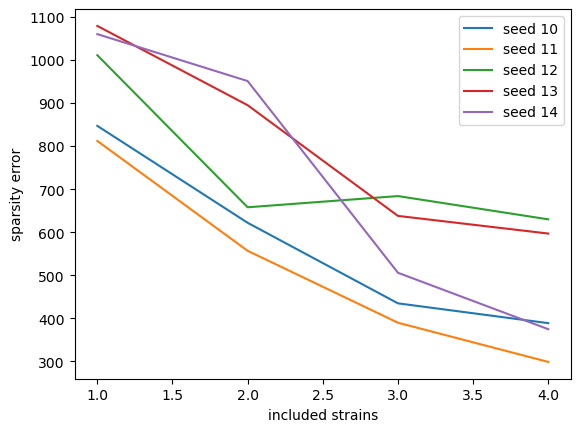

In [45]:
plt.plot([i+1 for i in range(4)],err2s.T, label=["seed 10", "seed 11", "seed 12", "seed 13", "seed 14"])
plt.ylabel("sparsity error")
plt.xlabel("included strains")
plt.legend()

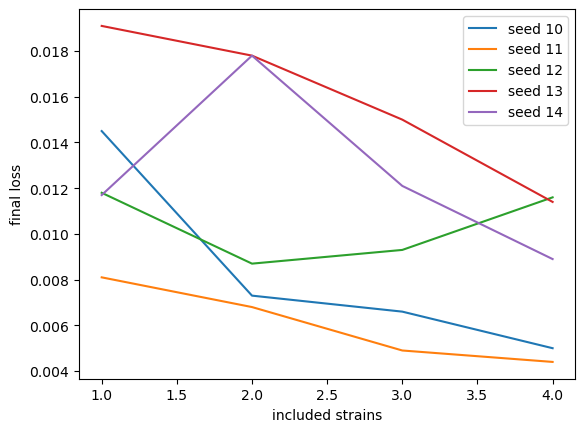

In [43]:
plt.plot([i+1 for i in range(4)],finalLoss.T, label=["seed 10", "seed 11", "seed 12", "seed 13", "seed 14"])
plt.ylabel("final loss")
plt.xlabel("included strains")
plt.legend()

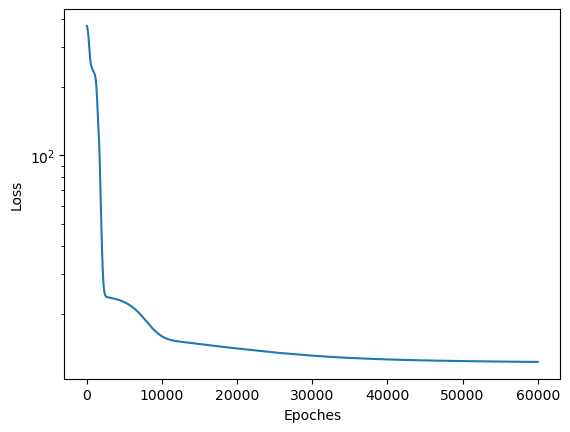

In [178]:
if plotFlag==1:
    plt.plot(losses)
    plt.yscale("log")
    plt.ylabel("Loss")
    plt.xlabel("Epoches")

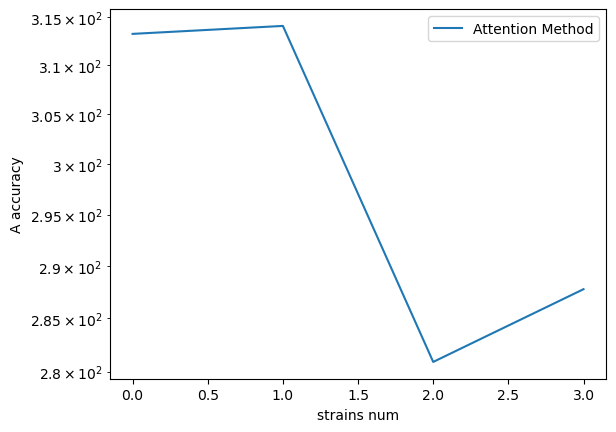

In [413]:
plt.plot(exper, label= "Attention Method")
#plt.plot(exper2, label= "Direct Method")
plt.xlabel("strains num")
plt.ylabel("A accuracy")
plt.yscale("log")
plt.legend()

tensor(0., device='cuda:0')
tensor(0.0002, device='cuda:0', grad_fn=<SelectBackward0>)


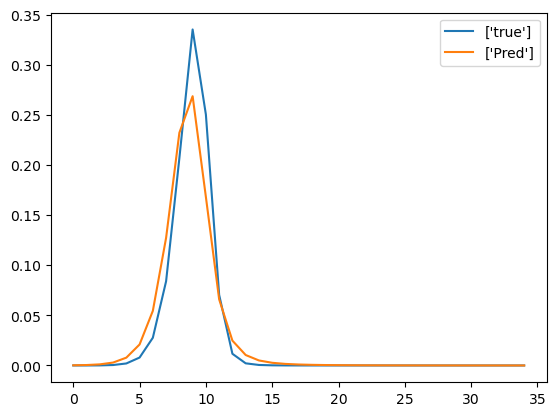

In [195]:
if plotFlag==1:
    node= 4
    plt.plot(signal[node, :, 1:].squeeze().T.cpu().detach(), label=paras.strains*["true"])
    utils.log_print(printFlag,signal[node, 0, 1])
    utils.log_print(printFlag,predSignal[node, 0, 0])
    #plt.plot(embedded_tensor[0, :, -1:].squeeze().T.cpu().detach())
    plt.plot(predSignal[node, :, 0:-1].squeeze().T.cpu().detach(), label=paras.strains*["Pred"])
    #plt.plot(noise[0].T.cpu().detach())
    plt.legend()